# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [5]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib

Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [6]:
from collections import Counter
import math



def gini(x):
    impurity = 1
    n = sum(x)
    for i in x:
        impurity -= (i/n)**2
    return impurity
        
    
def entropy(x):
    
    impurity = 0
    n = sum(x)
    for i in x:
        impurity -= (i/n) * math.log((i/n) + 1e-9, 2)
    return impurity

def gain(left_y, right_y, criterion):
    
    return criterion(left_y + right_y)  - (len(left_y)/(len(left_y) + len(right_y))
                                           * criterion(left_y) 
                                           + len(right_y)/(len(left_y) + len(right_y)) 
                                           * criterion(right_y))


Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [7]:
class DecisionTreeLeaf:
    def __init__(self, y, num_samples_per_class):
        self.left = None
        self.right = None
        self.y = y
        self.predict = {}
        s = sum(num_samples_per_class)
        for i in range(len(num_samples_per_class)):
            self.predict[i] = num_samples_per_class[i]/s
            

class DecisionTreeNode:
    def __init__(self,split_dim, split_value, left, right, 
                                       num_samples_per_class,
                                       predicted_class):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right


Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [8]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_leaf=1, criterion=gini):
        self.criterion = criterion
        if max_depth == None:
            self.max_depth = 1000
        else:
            self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.root = None
    
    def fit(self, X, y):
        self.classes = set(y)
        self.features = list(X.columns)
        self.root = self.grow_tree(X,y)
        
        
        
    def grow_tree(self, x, y, depth=0):
        X = x.copy() 
        num_samples = y.size
        num_samples_per_class = [np.sum(y == i) for i in self.classes] 
        predicted_class = np.argmax(num_samples_per_class)
        if depth < self.max_depth and num_samples > self.min_samples_leaf:
            idx, thr = self.best_split(X,y)
            if idx != None and thr != None:
                node = DecisionTreeNode(idx, thr, None, None, 
                                       num_samples_per_class = num_samples_per_class,
                                       predicted_class = predicted_class)
                X['y'] = y
                X_left, X_right = X[X[idx] < thr], X[X[idx] >= thr]
                y_left, y_right = X_left['y'], X_right['y']
                X_left, X_right = X_left.drop('y', 1), X_right.drop('y', 1)
                '''
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indicies_left]
                X_right, y_right = X[~indices_left], y[~indicies_left]
                '''
                node.left = self.grow_tree(X_left, y_left, depth + 1)
                node.right = self.grow_tree(X_right, y_right, depth + 1)
            else:
                node = DecisionTreeLeaf(predicted_class, num_samples_per_class)
        else:
            node = DecisionTreeLeaf(predicted_class, num_samples_per_class)
        return node


    def best_split(self, X, y):
        df = X.copy()
        df['y'] = y.copy() #заменил на копи
        max_gain = 0
        best_feature = None
        best_value = None
        for feature in self.features:
            xdf = df.sort_values(feature)
            xvalues = xdf[feature].unique()
            for value in xvalues:
                left_counts = Counter(xdf[xdf[feature] < value]['y'])
                right_counts = Counter(xdf[xdf[feature] >= value]['y'])
                n_left = sum(list(left_counts.values()))
                n_right = sum(list(right_counts.values()))
                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue
                main_gain = gain(list(left_counts.values()), list(right_counts.values()), self.criterion)
                '''
                gini_left = self.gini(list(left_counts.values())) # использум пока джини
                gini_right = self.gini(list(right_counts.values())) # использую пока джини
                w_left = n_left/(n_left + n_right)
                w_right = n_right/(n_left + n_right)
                w_gini = w_left * gini_left + w_right * gini_right
                gini_gain = ngini - w_gini
                '''
                if main_gain > max_gain:
                    best_feature = feature
                    best_value = value 
                    max_gain = main_gain
        return best_feature, best_value
    
    def predict_proba(self, X):
        for_return = []
        for _, x in X.iterrows():
            node = self.root
            while node.left:
                if x[node.split_dim] < node.split_value:
                    node = node.left
                else:
                    node = node.right
            
            for_return.append(node.predict)
        return for_return
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [9]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (int(tree_root.split_dim), tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [10]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()


Протестируйте решение на датасете spam.
Для этой задачи используйте данные x_spam_train и y_spam_train:
1. Выполните загрузку и предобработку файлов x_spam_train и y_spam_train.
2. Разбейте x_spam_train и y_spam_train на x_train, y_train, x_test и y_test для оценки точности работы алгоритма.
3. Посчитайте метрики `precision`, `recall`, `accuracy` для модели Decision Tree. Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.
4. Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`).
5. Ответьте на следующие вопросы:
    - Какой нужен препроцессинг данных для моделей?
    - Какая модель делает предсказания лучше?  Предположите, почему.

ЛУчше предсказывает DecisionTree, возможно потому что оно просчиты

In [11]:
import random

from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier


DATA_PATH_X = '/Users/vasilijdronov/Machine learning/x_spam_train.csv'
DATA_PATH_Y = '/Users/vasilijdronov/Machine learning/y_spam_train.csv'

x_spam_train = pd.read_csv(DATA_PATH_X)
y_spam_train = pd.read_csv(DATA_PATH_Y)
del x_spam_train['Id']
del y_spam_train['Id']
df = x_spam_train.copy()
df['expected'] = y_spam_train.copy()
border = int(len(df) * 0.7)
x_train = df[:border]
x_test = df[border:]
x_test.index = np.arange(len(x_test))
y_test = x_test['expected']
y_train = x_train['expected']
del x_train['expected']
del x_test['expected']




root = DecisionTreeClassifier(5, 3, entropy)
root.fit(x_train, y_train)

rr = root.predict(x_test)


print('Tree:')
print(accuracy_score(y_test, rr))
print(recall_score(y_test, rr))
print(precision_score(y_test, rr))



print('kNN:')
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train, y_train)
r = neigh.predict(x_test)
print(accuracy_score(y_test, r))
print(recall_score(y_test, r))
print(precision_score(y_test, r))





Tree:
0.8315217391304348
0.7342342342342343
0.8274111675126904
kNN:
0.7807971014492754
0.7184684684684685
0.731651376146789


In [12]:
import random

from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier


DATA_PATH_X = '/Users/vasilijdronov/Machine learning/x_spam_train.csv'
DATA_PATH_Y = '/Users/vasilijdronov/Machine learning/y_spam_train.csv'

x_spam_train = pd.read_csv(DATA_PATH_X)
y_spam_train = pd.read_csv(DATA_PATH_Y)
ID = x_spam_train['Id']
print('ID: ', ID)
del x_spam_train['Id']
del y_spam_train['Id']
df = x_spam_train.copy()
df['expected'] = y_spam_train.copy()
border = int(len(df) * 0.7)
ID_test = ID[border:]
print('ID_test: ', ID_test)
x_train = df[:border]
x_test = df[border:]
x_test.index = np.arange(len(x_test))
y_test = x_test['expected']
y_train = x_train['expected']
del x_train['expected']
del x_test['expected']




root = DecisionTreeClassifier(5, 3, entropy)
root.fit(x_train, y_train)

rr = root.predict(x_test)


print('Tree:')
print(accuracy_score(y_test, rr))
print(recall_score(y_test, rr))
print(precision_score(y_test, rr))



print('kNN:')
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train, y_train)
r = neigh.predict(x_test)
print(accuracy_score(y_test, r))
print(recall_score(y_test, r))
print(precision_score(y_test, r))

ID:  0          0
1          1
2          2
3          3
4          4
        ... 
3675    3675
3676    3676
3677    3677
3678    3678
3679    3679
Name: Id, Length: 3680, dtype: int64
ID_test:  2576    2576
2577    2577
2578    2578
2579    2579
2580    2580
        ... 
3675    3675
3676    3676
3677    3677
3678    3678
3679    3679
Name: Id, Length: 1104, dtype: int64
Tree:
0.8315217391304348
0.7342342342342343
0.8274111675126904
kNN:
0.7807971014492754
0.7184684684684685
0.731651376146789


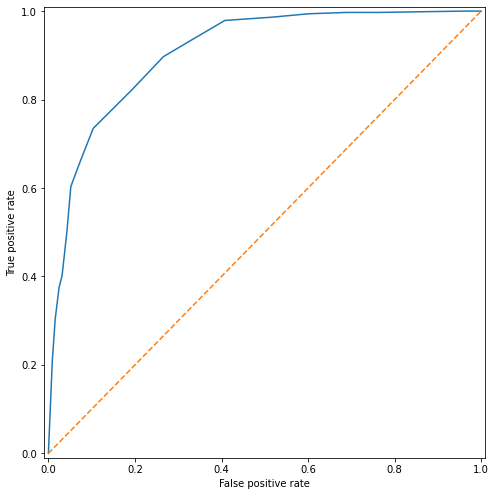

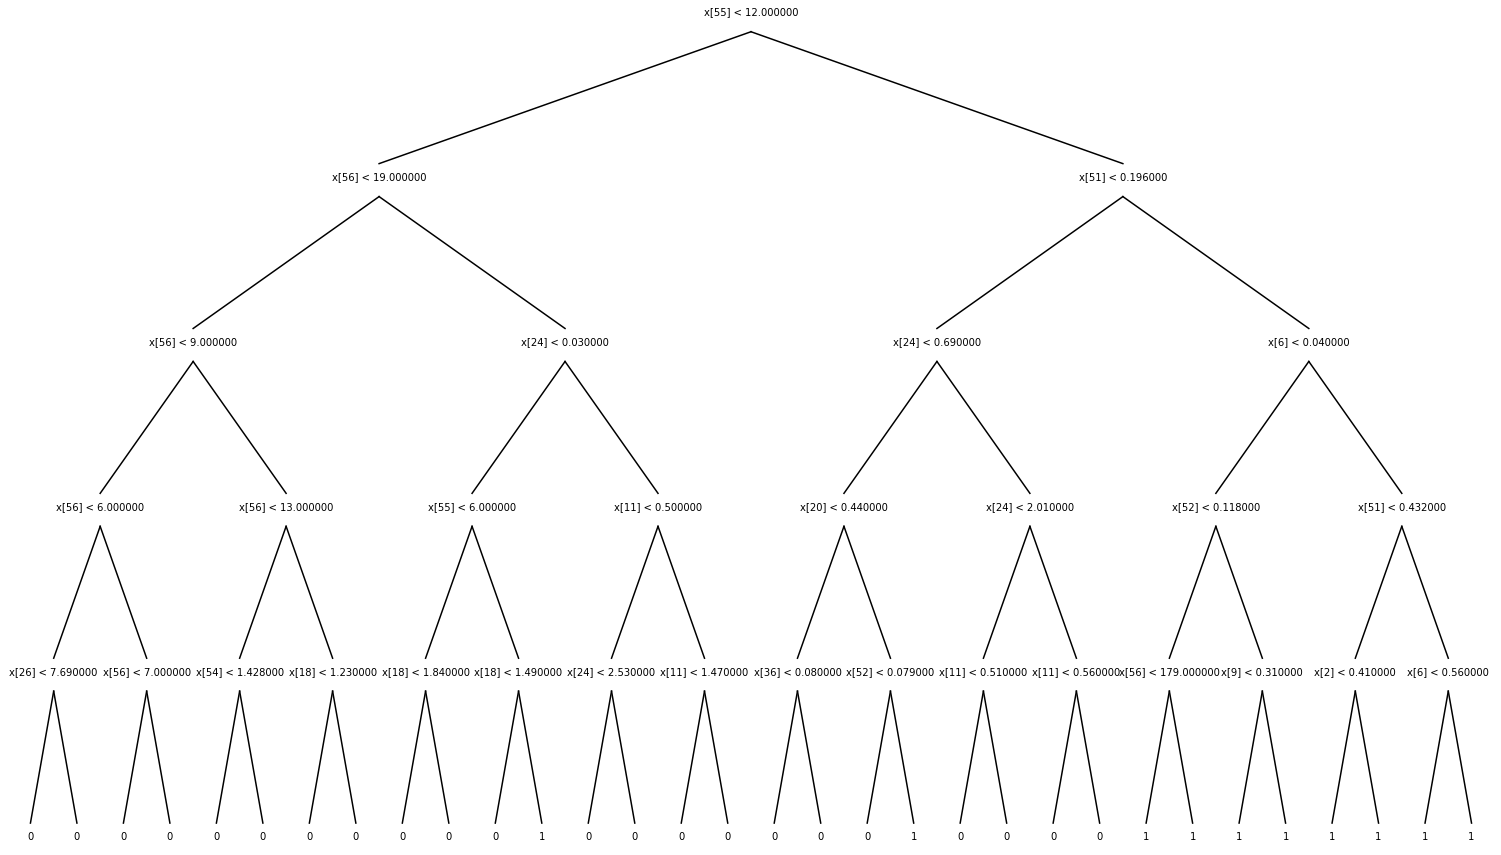

In [14]:
#tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
#tree.fit(x_train, y_train)
plot_roc_curve(y_test, root.predict_proba(x_test))
draw_tree(root)

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [19]:
DATA_PATH_test = '/Users/vasilijdronov/Machine learning/x_spam_test.csv'
test = pd.read_csv(DATA_PATH_test)
pred = root.predict(test)
test.Id

0        0
1        1
2        2
3        3
4        4
      ... 
916    916
917    917
918    918
919    919
920    920
Name: Id, Length: 921, dtype: int64

In [21]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = test.Id
submission["Expected"] = pred
submission.to_csv('submission.csv', index=False)
